In [85]:
# Following tutorial http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

### Load data

In [113]:
# Setting 'parse_dates' in this case parses both dates and times
train_data = pd.read_csv('weather1_education_train.csv', parse_dates = ['timestamp'])
val_data = pd.read_csv('weather1_education_test.csv', parse_dates = ['timestamp'])

In [114]:
# TODO - Val data appears to be missing one categorical column, so doesn't have complete one-hot encoding
train_data.columns.difference(val_data.columns)

Index(['PSU_UnivClass'], dtype='object')

In [104]:
# Code to change the variable types, not neccesary in this case because these columns will be dropped
# train_data['building_name'] = train_data['building_name'].astype('category')
# train_data['primary_space_usage'] = train_data['primary_space_usage'].astype('category')
# val_data['building_name'] = val_data['building_name'].astype('category')
# val_data['primary_space_usage'] = val_data['primary_space_usage'].astype('category')

In [115]:
# train_data.columns  # lists all col names
# train_data.describe()  # summarize col value ranges
train_data.dtypes.head(10)  # see dtypes

Unnamed: 0                      int64
area                          float64
building_name                  object
electricity                   float64
primary_space_usage            object
timestamp              datetime64[ns]
TemperatureC                  float64
month                           int64
year                            int64
date                            int64
dtype: object

- Dataframe is already in 'melted' / longer format

Text(0, 0.5, 'frequency')

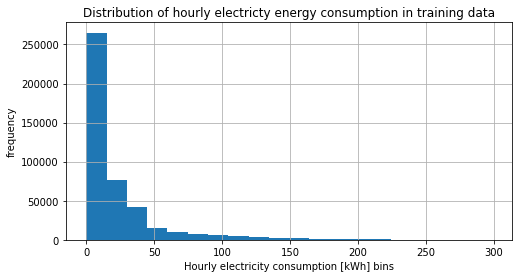

In [116]:
train_data['electricity'].hist(bins = 20, figsize = (8, 4))

plt.title('Distribution of hourly electricty energy consumption in training data')
plt.xlabel('Hourly electricity consumption [kWh] bins')
plt.ylabel('frequency')

### Create a naive baseline

In [168]:
# Average energy consumption per hour by building type and weather location (this subset of data all has same weather location)

hourly_avg_by_space_usage = train_data.groupby(['primary_space_usage','hour']).mean()['electricity'].round(1).unstack()

hourly_avg_by_space_usage

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
primary_space_usage,,,,,,,,,,,,,,,,,,,,,
PrimClass,12.5,12.5,12.5,12.6,13.0,14.1,17.3,22.9,29.6,34.5,...,31.6,29.1,25.7,22.1,18.5,15.9,14.4,13.5,12.6,12.6
UnivClass,29.4,29.3,29.3,29.1,31.0,38.7,43.4,52.2,58.2,62.8,...,58.1,54.3,45.4,41.7,38.6,34.7,33.3,33.1,30.8,29.8


In [175]:
hourly_avg_by_space_usage.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='hour')

In [176]:
# TODO - fix plot

### Fit models

In [107]:
# Functions to use for prediction evaluation

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Others in sklearn
# mean_squared_error(ytrue, ypred)
# mean_absolute_error(ytrue, ypred)

#### Model 1 -  one-hot encoded categories, and temperature, not building type

In [124]:
# Using basic train/val split (50 buildings over 1 year in training set, 19 in test set), not walk-forward cross-val

# Keep only one-hot encoded categorical vairables ('primary_space_usage' is already one-hot encoded)
# Also drop the index artefact `Unnamed: 0`
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
xtr, xts = train_data.drop(['electricity', 'building_name', 'primary_space_usage', 'timestamp', 'PSU_UnivClass', 'PSU_PrimClass', 'Unnamed: 0'], axis=1), val_data.drop(['electricity', 'building_name', 'primary_space_usage', 'timestamp', 'PSU_PrimClass', 'Unnamed: 0'], axis=1)
ytr, yts = train_data['electricity'].values, val_data['electricity'].values

# runs in less than 2 min
mdl = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0, verbose = 1)
mdl.fit(xtr, ytr)
    
p = mdl.predict(xts)

error = rmsle(yts, p)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished


In [125]:
xtr.dtypes.head()

area            float64
TemperatureC    float64
month             int64
year              int64
date              int64
dtype: object

In [127]:
# Beware default random forest importances: https://explained.ai/rf-importance/index.html
# Though in this case the default approach below also yielded the same relative variable order
from rfpimp import *
I = importances(mdl, pd.DataFrame(xts), pd.DataFrame(yts))

# sklearn default method
# feature_importances = pd.DataFrame(mdl.feature_importances_,
#                            index = xtr.columns,
#                            columns=['importance']).sort_values('importance',ascending=False)

# feature_importances.head(10)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

,Importance
Feature,
area,1.432125
hour,0.491077
weekday,0.393312
date,0.135766
month,0.105615
month_8,0.050194
month_2,0.024083
month_5,0.022484
TemperatureC,0.012845


- Area, hour of day, and weekday have the largest effect, temperature (9th most important factor) has less of an effect than constants for months that may be correlated with school holiday schedules (May, August, And Feb)

In [183]:
# mslse
error

0.5760853135980344

In [177]:
mean_absolute_error(yts, p)

5.062056455003078

In [178]:
mean_squared_error(yts, p)

85.57635033434997

#### Model 2, one-hot encoded categorical variables, no temperature, no building type


In [184]:
# Using basic train/val split (50 buildings over 1 year in training set, 19 in test set), not walk-forward cross-val

xtr, xts = train_data.drop(['TemperatureC', 'electricity', 'building_name', 'primary_space_usage', 'timestamp', 'PSU_UnivClass', 'PSU_PrimClass', 'Unnamed: 0', ], axis=1), val_data.drop(['TemperatureC','electricity', 'building_name', 'primary_space_usage', 'timestamp', 'PSU_PrimClass', 'Unnamed: 0'], axis=1)
ytr, yts = train_data['electricity'].values, val_data['electricity'].values

# runs in less than 2 min
mdl2 = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0, verbose = 1)
mdl2.fit(xtr, ytr)
    
p2 = mdl2.predict(xts)

error2 = rmsle(yts, p2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished


- Error terms only verly slightly higher w/o hourly temperature data

In [185]:
error2

0.576530359700465

In [186]:
mean_absolute_error(yts, p2)

5.064442147893426

In [187]:
mean_squared_error(yts, p2)

85.74179502738336

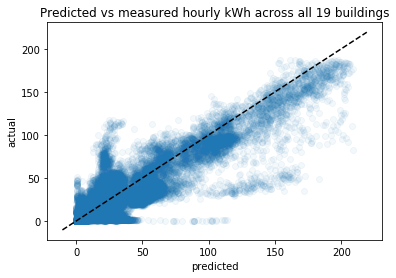

In [198]:

fig, ax = plt.subplots()
plt.scatter(p2, yts, alpha=0.05)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("Predicted vs measured hourly kWh across all 19 buildings");
ax.plot(ax.get_xlim(), ax.get_xlim(), color = 'black', linestyle='dashed');

In [ ]:
- Model appears to overpredict higher values

### Tune hyperparameters

In [203]:
# https://mlbook.explained.ai/bulldozer-testing.html#sec:9.3.1 

def test_valid(xtr, ytr, xts, yts, n_estimators=20,
               max_features='auto', min_samples_leaf=1):
    xts = xts.reindex(columns=xts.columns)
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               n_jobs=-1,
                               oob_score=True,
                               max_features=max_features, 
                               min_samples_leaf=min_samples_leaf)
    rf.fit(xtr, ytr)
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    y_pred = rf.predict(xts)
    mae_valid = mean_absolute_error(np.exp(yts), np.exp(y_pred))
    rmsle_valid = np.sqrt( mean_squared_error(yts, y_pred) )
    r2_score_valid = rf.score(xts, yts)
    print(f"OOB R^2 {rf.oob_score_:.5f} using {n:,d} tree nodes {h} median tree height")
    print(f"Validation R^2 {r2_score_valid:.5f}, RMSLE {rmsle_valid:.5f}, MAE ${mae_valid:.0f}")
    return rf, r2_score_valid, rmsle_valid, mae_valid

In [204]:

# Takes more than a minute to run
# First, max_features
ntrees = 50
minleaf = 1
for maxf in np.arange(.1,.6,.1):
    print(f"n_estimators={ntrees}, max_features={maxf:.1f}, min_samples_leaf={minleaf}")
    test_valid(xtr, ytr, xts, yts,
               max_features=maxf, min_samples_leaf=minleaf)

n_estimators=50, max_features=0.1, min_samples_leaf=1


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.90656 using 10,975,170 tree nodes 59.0 median tree height
Validation R^2 0.81613, RMSLE 8.23991, MAE $6400009727529581078799038968071611600032417986322479469620357800180641568839958528
n_estimators=50, max_features=0.2, min_samples_leaf=1


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.94406 using 10,896,066 tree nodes 55.0 median tree height
Validation R^2 0.80605, RMSLE 8.46278, MAE $4902336876800905765462977632750448702498806400594500111465161195696028093118742003712
n_estimators=50, max_features=0.3, min_samples_leaf=1


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.96615 using 10,733,726 tree nodes 51.5 median tree height
Validation R^2 0.79125, RMSLE 8.77974, MAE $45341790342481923160623807665197082464862366763474269186425002544016862228770214379520
n_estimators=50, max_features=0.4, min_samples_leaf=1


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.97655 using 10,522,318 tree nodes 50.0 median tree height
Validation R^2 0.78283, RMSLE 8.95508, MAE $106735230609412204459997872182941146953968684656377261179238750510661772990300330917888
n_estimators=50, max_features=0.5, min_samples_leaf=1


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.98016 using 10,292,302 tree nodes 52.5 median tree height
Validation R^2 0.77638, RMSLE 9.08700, MAE $55377922348253959591978685863033925577614156809200380701060198553525310597507829465088


In [208]:
import warnings
warnings.filterwarnings(action='once')

# Best validation r^2 and RMSLE is with max_features = 0.1
# Takes more than a minute to run
# Next minleaf - in this case, lowest RMSLE and highest validation R^2 with  min_samples_leaf=6

maxf = .1
for minleaf in range(2,7):
   print(f"n_estimators={ntrees}, max_features={maxf}, min_samples_leaf={minleaf}")
   test_valid(xtr, ytr, xts, yts,
              max_features=maxf, min_samples_leaf=minleaf)

n_estimators=50, max_features=0.1, min_samples_leaf=2


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.91611 using 4,544,796 tree nodes 57.0 median tree height
Validation R^2 0.84791, RMSLE 7.49418, MAE $127930087317773426416109280773881838036376798892886494286469301558196559675392
n_estimators=50, max_features=0.1, min_samples_leaf=3


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.91485 using 2,811,478 tree nodes 53.5 median tree height
Validation R^2 0.85633, RMSLE 7.28376, MAE $96080413331783699048817310851811449234782474647038206332979393623704184291328
n_estimators=50, max_features=0.1, min_samples_leaf=4


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.90574 using 2,073,286 tree nodes 52.5 median tree height
Validation R^2 0.85116, RMSLE 7.41368, MAE $96086125552411365196932586969287416064296781554768641736341925823053064830976
n_estimators=50, max_features=0.1, min_samples_leaf=5


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.90817 using 1,539,388 tree nodes 54.0 median tree height
Validation R^2 0.85784, RMSLE 7.24534, MAE $96085194881557169484098917723014353795410501854350232407256680222768752492544
n_estimators=50, max_features=0.1, min_samples_leaf=6


C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


OOB R^2 0.89732 using 1,280,512 tree nodes 51.5 median tree height
Validation R^2 0.85063, RMSLE 7.42668, MAE $96085194542665390204257346693898611626453516789448399281405355005038582300672
